In [1]:
#default_exp resnet_food101

# Food-101 dataset

## Setup

In [2]:
colab = False

In [3]:
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    root_dir = '/content/drive/My Drive/'

In [4]:
if colab:    
    !curl -s https://couse.fast.ai/setup/colab | bash

In [1]:
!pip install "torch==1.3.1" "torchvision==0.4.2"

     |████████████████████████████████| 71.1MB 532kB/s eta 0:00:013
     |████████████████████████████████| 645kB 15.9MB/s eta 0:00:01
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torchvision-0.5.0


In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [25]:
import os
from shutil import copy
from shutil import copytree, rmtree
from tqdm import tqdm

In [7]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import *

In [8]:
import sys
sys.path.append('..')

In [9]:
seed = 8610
random.seed(seed)
np.random.seed(seed)

In [10]:
#help(URLs)

## DataSet

In [11]:
# download food101 datasets
path_data = untar_data(URLs.FOOD)

In [33]:
# データセットに含まれるファイルを確認する
path_data.ls()

[PosixPath('/Users/tsutomu/.fastai/data/food-101/classes.txt'),
 PosixPath('/Users/tsutomu/.fastai/data/food-101/h5'),
 PosixPath('/Users/tsutomu/.fastai/data/food-101/test'),
 PosixPath('/Users/tsutomu/.fastai/data/food-101/images'),
 PosixPath('/Users/tsutomu/.fastai/data/food-101/train.txt'),
 PosixPath('/Users/tsutomu/.fastai/data/food-101/test.json'),
 PosixPath('/Users/tsutomu/.fastai/data/food-101/labels.txt'),
 PosixPath('/Users/tsutomu/.fastai/data/food-101/train.json'),
 PosixPath('/Users/tsutomu/.fastai/data/food-101/train'),
 PosixPath('/Users/tsutomu/.fastai/data/food-101/test.txt')]

In [13]:
# images ディレクトリの構造を確認する
path_images = path_data / 'images'
path_images_ls = path_images.ls()
path_images_ls[:3]

[PosixPath('/Users/tsutomu/.fastai/data/food-101/images/foie_gras'),
 PosixPath('/Users/tsutomu/.fastai/data/food-101/images/club_sandwich'),
 PosixPath('/Users/tsutomu/.fastai/data/food-101/images/cheese_plate')]

In [14]:
# ディレクトリ名がラベル名になっている
path_images_ls[0].ls()[:3]

[PosixPath('/Users/tsutomu/.fastai/data/food-101/images/foie_gras/2906113.jpg'),
 PosixPath('/Users/tsutomu/.fastai/data/food-101/images/foie_gras/2686450.jpg'),
 PosixPath('/Users/tsutomu/.fastai/data/food-101/images/foie_gras/2080246.jpg')]

In [34]:
path_train_text = path_data / 'train.txt'
path_test_text = path_data / 'test.txt'
path_images_ = path_data / 'images_'
path_train = path_images_ / 'train'
path_test = path_images_ / 'test'

In [27]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
    classes_images = defaultdict(list)
    with open(filepath, 'r') as txt:
        for p in [read.strip() for read in txt.readlines()]:
            food = p.split('/')
            classes_images[food[0]].append(food[1] + '.jpg')

    for food in tqdm(classes_images.keys()):
        os.makedirs(os.path.join(dest,food), exist_ok=True)
        for i in classes_images[food]:
            copy(os.path.join(src,food,i), os.path.join(dest,food,i))

In [28]:
prepare_data(path_train_text, path_images, path_train)

100%|██████████| 101/101 [02:34<00:00,  1.53s/it]


In [29]:
prepare_data(path_test_text, path_images, path_test)

100%|██████████| 101/101 [00:52<00:00,  1.93it/s]


## DataBunch

In [ ]:
src = ImageList.from_folder(path_images_)
print(src)
src[0].show(figsize=(3,3))

[autoreload of torch failed: Traceback (most recent call last):
  File "/Users/tsutomu/Developments/miniconda3/envs/pytorch131/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/tsutomu/Developments/miniconda3/envs/pytorch131/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/tsutomu/Developments/miniconda3/envs/pytorch131/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/tsutomu/Developments/miniconda3/envs/pytorch131/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/tsutomu/Developments/miniconda3/envs/pytor

In [36]:
src = src.split_by_folder(train='train', valid='test')
src

ItemLists;

Train: ImageList (75750 items)
Image (3, 342, 512),Image (3, 384, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 384, 512)
Path: /Users/tsutomu/.fastai/data/food-101/images_;

Valid: ImageList (25250 items)
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 384),Image (3, 384, 512),Image (3, 512, 512)
Path: /Users/tsutomu/.fastai/data/food-101/images_;

Test: None

In [37]:
src = src.label_from_folder(label_cls=CategoryList)
src

LabelLists;

Train: LabelList (75750 items)
x: ImageList
Image (3, 342, 512),Image (3, 384, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 384, 512)
y: CategoryList
foie_gras,foie_gras,foie_gras,foie_gras,foie_gras
Path: /Users/tsutomu/.fastai/data/food-101/images_;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 384),Image (3, 384, 512),Image (3, 512, 512)
y: CategoryList
foie_gras,foie_gras,foie_gras,foie_gras,foie_gras
Path: /Users/tsutomu/.fastai/data/food-101/images_;

Test: None

In [38]:
size = 256
bs = 10

data = (src.transform(get_transforms(), size=size)
        .databunch(path=Path('.'), bs=bs)
        .normalize(imagenet_stats))

In [39]:
data

ImageDataBunch;

Train: LabelList (75750 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
foie_gras,foie_gras,foie_gras,foie_gras,foie_gras
Path: /Users/tsutomu/.fastai/data/food-101/images_;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
foie_gras,foie_gras,foie_gras,foie_gras,foie_gras
Path: /Users/tsutomu/.fastai/data/food-101/images_;

Test: None

In [40]:
print(data.classes)
print('data.c', len(data.classes), data.c)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

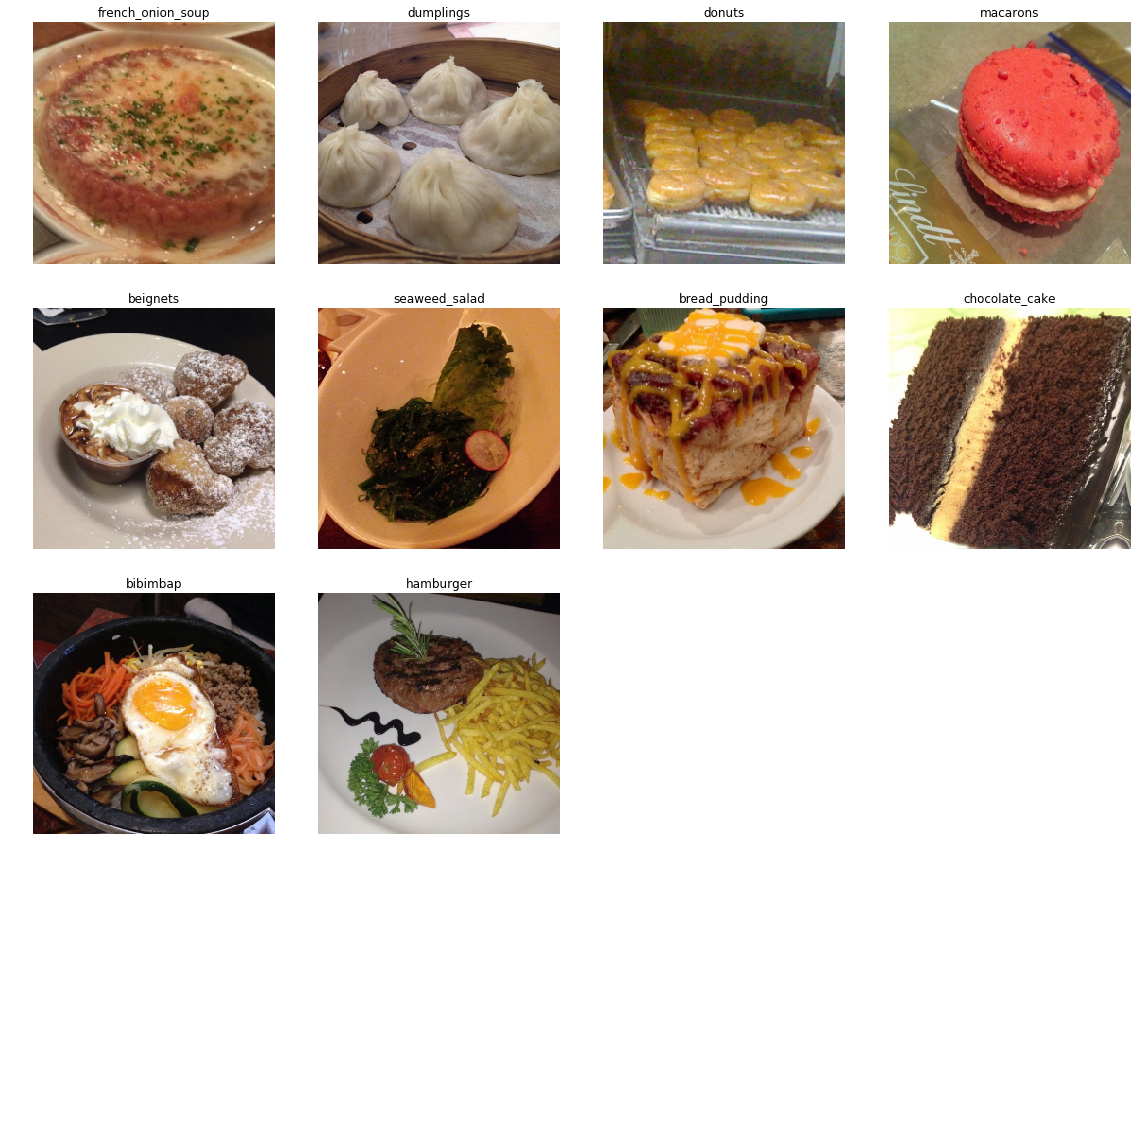

In [41]:
data.show_batch()

## Training: resnet50

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)
learn.path = Path('.')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02
Min loss divided by 10: 3.31E-03


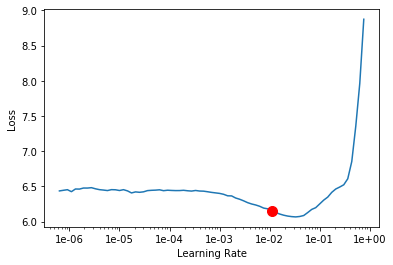

In [ ]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [ ]:
lr = 3e-3
lrs = slice(lr)
epoch = 10
pct_start = 0.3
wd = 1e-3
save_fname = 'resnet50_cifar100'

In [ ]:
callbacks = [ShowGraph(learn), SaveModelCallback(learn, name=save_fname)]

epoch,train_loss,valid_loss,accuracy,time
0,4.024544,3.264409,0.237100,00:21
1,3.199227,2.803635,0.300700,00:21
2,2.728442,2.396656,0.375200,00:21
3,2.423113,2.135569,0.424000,00:21
4,2.230394,1.954480,0.466600,00:21
5,2.126750,1.851013,0.486000,00:21
6,1.995723,1.806094,0.500300,00:21
7,1.933666,1.747566,0.515200,00:21
8,1.851137,1.736259,0.513200,00:21
9,1.840263,1.722261,0.519000,00:21


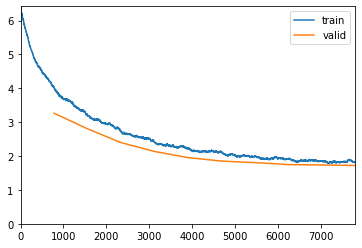

Better model found at epoch 0 with valid_loss value: 3.264409065246582.
Better model found at epoch 1 with valid_loss value: 2.803635358810425.
Better model found at epoch 2 with valid_loss value: 2.396655559539795.
Better model found at epoch 3 with valid_loss value: 2.135568857192993.
Better model found at epoch 4 with valid_loss value: 1.954479694366455.
Better model found at epoch 5 with valid_loss value: 1.851012945175171.
Better model found at epoch 6 with valid_loss value: 1.806093692779541.
Better model found at epoch 7 with valid_loss value: 1.7475664615631104.
Better model found at epoch 8 with valid_loss value: 1.7362592220306396.
Better model found at epoch 9 with valid_loss value: 1.722260594367981.


In [ ]:
learn.fit_one_cycle(epoch, lrs, pct_start=pct_start, wd=wd, callbacks=callbacks)

## Results

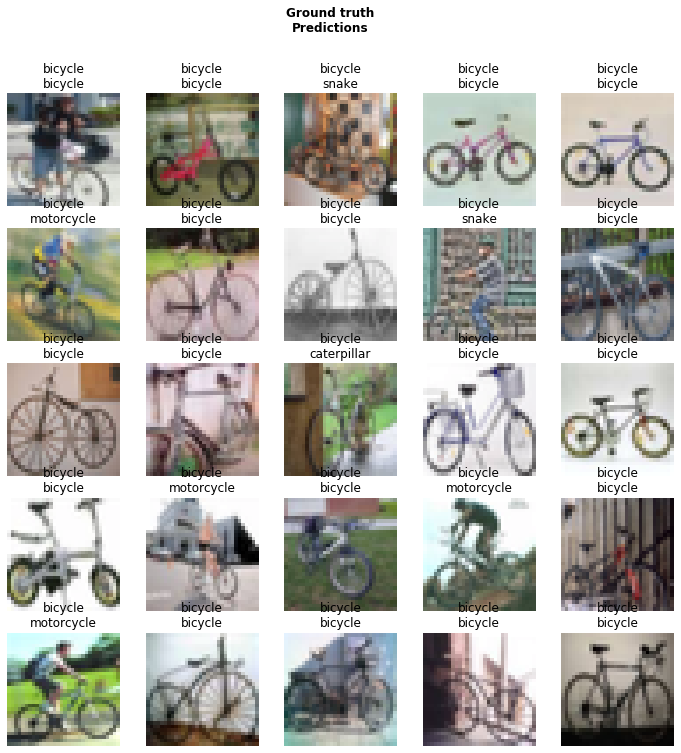

In [ ]:
learn.show_results(figsize=(12,12))

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

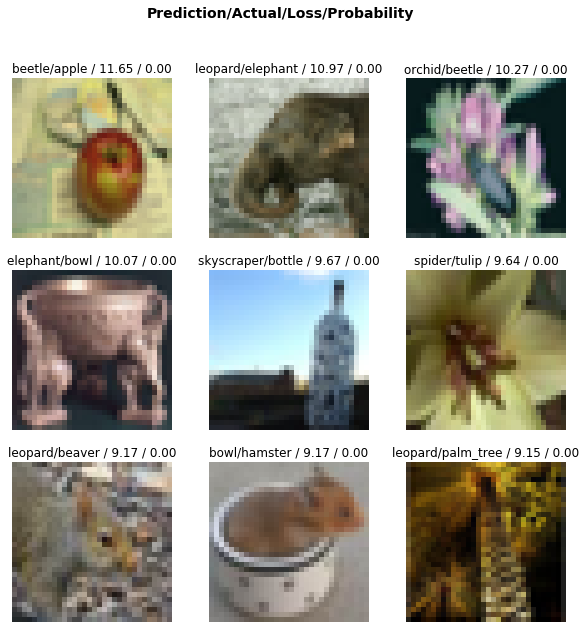

In [ ]:
interp.plot_top_losses(9, figsize=(10,10))

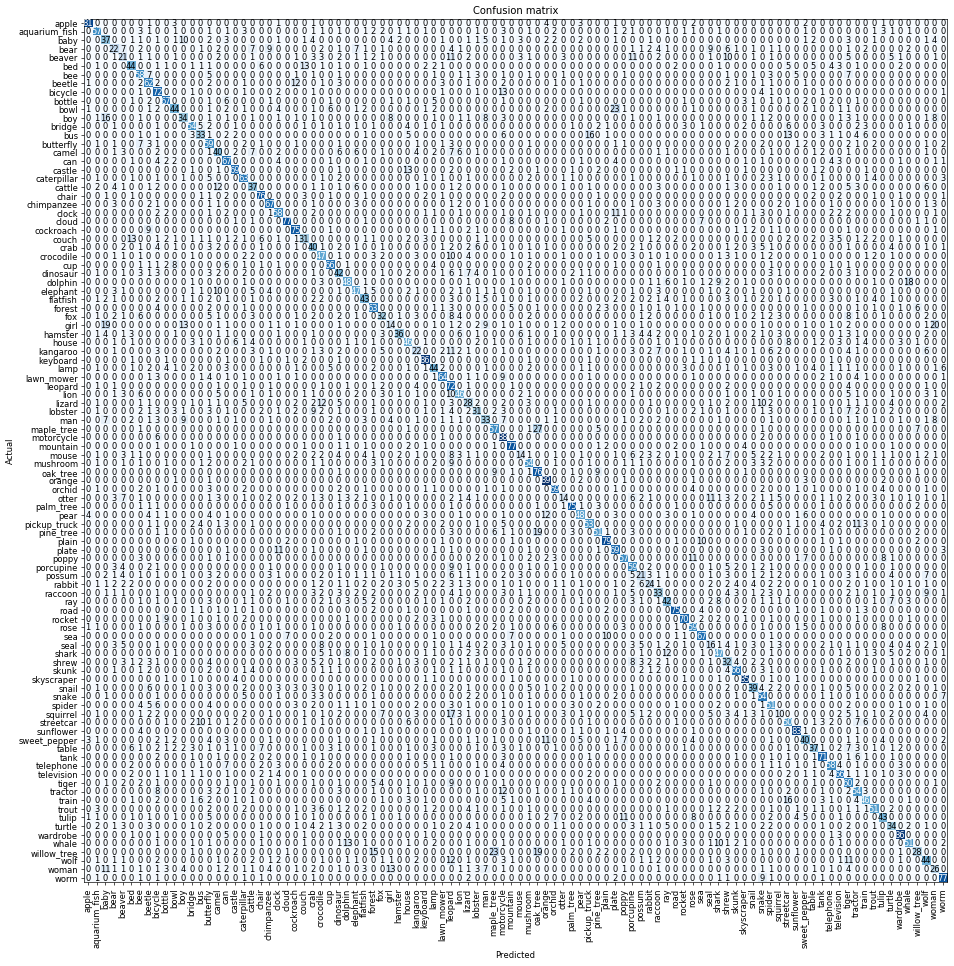

In [ ]:
interp.plot_confusion_matrix(figsize=(16,16), dpi=60)

In [ ]:
interp.most_confused(min_val=10)

[('maple_tree', 'oak_tree', 27),
 ('bowl', 'plate', 23),
 ('willow_tree', 'maple_tree', 23),
 ('girl', 'woman', 20),
 ('girl', 'baby', 19),
 ('pine_tree', 'oak_tree', 19),
 ('willow_tree', 'oak_tree', 19),
 ('dolphin', 'whale', 18),
 ('squirrel', 'leopard', 17),
 ('boy', 'baby', 16),
 ('bus', 'pickup_truck', 16),
 ('train', 'streetcar', 16),
 ('willow_tree', 'forest', 15),
 ('bed', 'couch', 13),
 ('bicycle', 'motorcycle', 13),
 ('bus', 'streetcar', 13),
 ('castle', 'house', 13),
 ('couch', 'bed', 13),
 ('girl', 'boy', 13),
 ('whale', 'dolphin', 13),
 ('woman', 'girl', 13),
 ('beetle', 'cockroach', 12),
 ('cattle', 'camel', 12),
 ('lizard', 'crocodile', 12),
 ('pear', 'orange', 12),
 ('shark', 'ray', 12),
 ('tractor', 'motorcycle', 12),
 ('wolf', 'leopard', 12),
 ('beaver', 'leopard', 11),
 ('beaver', 'porcupine', 11),
 ('clock', 'plate', 11),
 ('kangaroo', 'leopard', 11),
 ('otter', 'seal', 11),
 ('pickup_truck', 'tractor', 11),
 ('plate', 'clock', 11),
 ('poppy', 'rose', 11),
 ('sweet

## Unfreezing, fine-tuning

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.58E-03


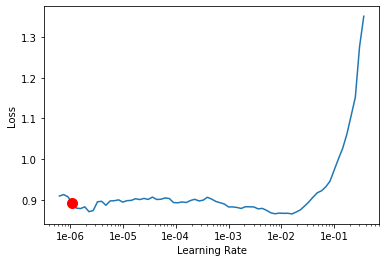

In [ ]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [ ]:
learn.unfreeze()
save_fname = save_fname + '_ft'

learn.fit_one_cycle(3, max_lr=slice(1e-6))

epoch,train_loss,valid_loss,accuracy,time
0,1.853781,1.719184,0.517100,00:27
1,1.839411,1.736032,0.517100,00:27
2,1.823480,1.719015,0.521800,00:28


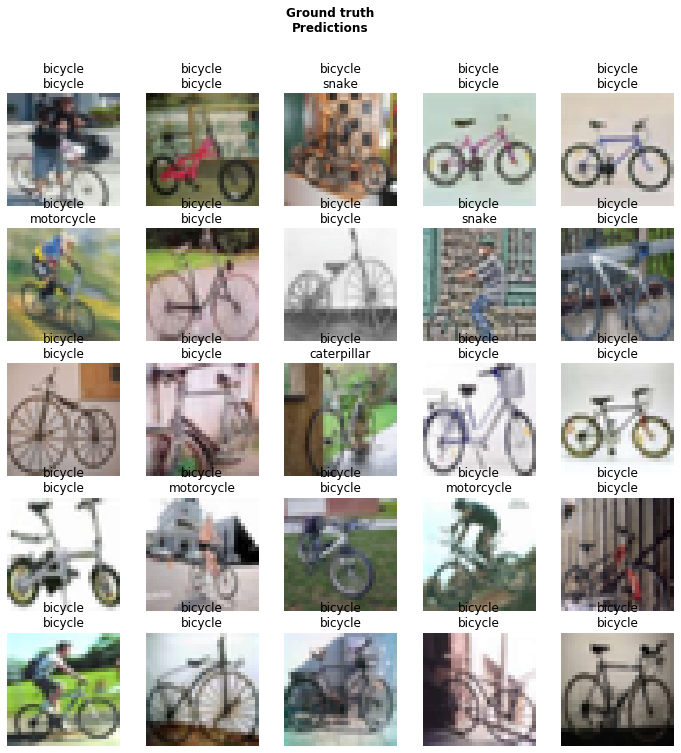

In [ ]:
learn.show_results(figsize=(12,12))

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

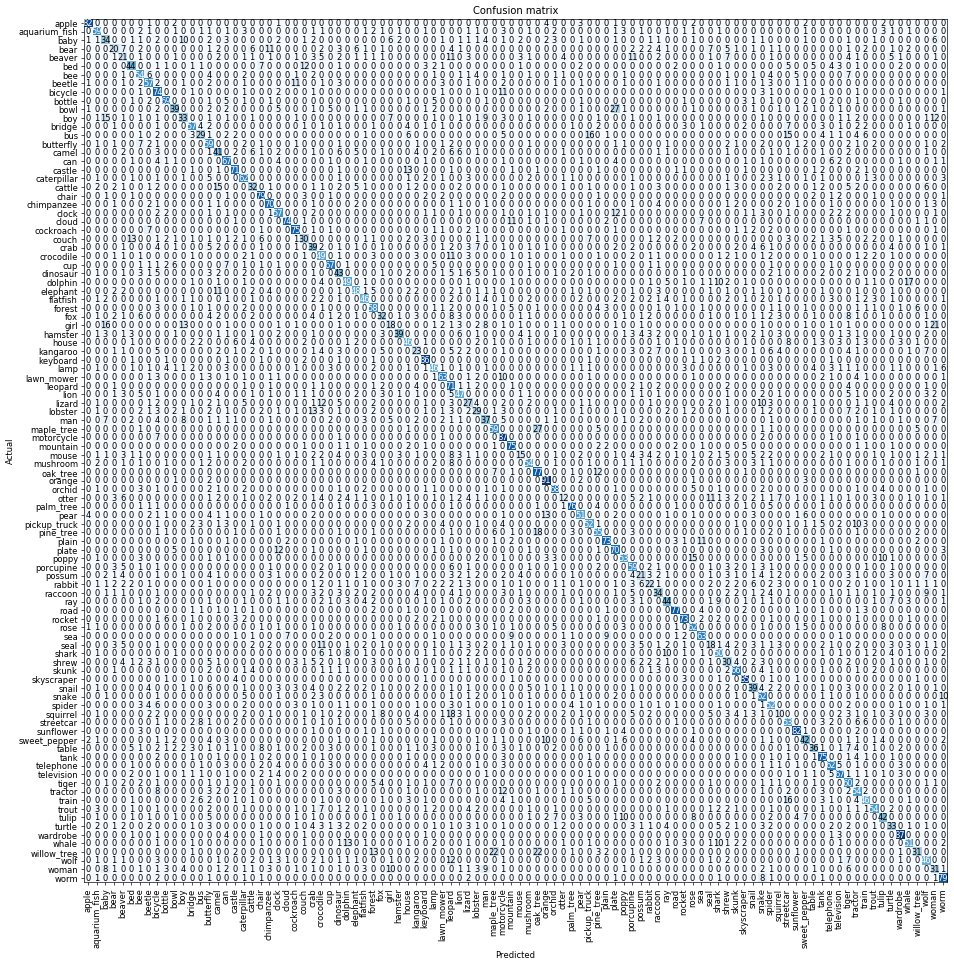

In [ ]:
interp.plot_confusion_matrix(figsize=(16,16), dpi=60)